# Advection with Flux Limiters
## From CHEN 6355 as taught by Tony Saad at the University of Utah
<a>www.tonysaad.net</a>
<hr/>

In [2]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'html5'
from matplotlib import cm

In [6]:
def step(x):
    x0 = 0.6
    x1 = 0.8
    result = x - x0
    result[x-x1<x1] = 1.0
    result[x<x0] = 0.
    result[x>x1] = 0.
    return result

def gaussian(x, x0):
    s = 0.08
    s = s*s
    result = np.exp(-(x-x0)**2/s)
    return result

In [1]:
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get("https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css")
    return HTML(styles.text)
css_styling()

The equation to be solved is the one-dimensional linear advection equations:

$$u_t = -cu_x = -F_x; \quad F=cu$$

This will be accomplished with a simple forward Euler and a finite volume integration scheme:

$$u_i^{n+1} = u_i^n - \frac{\Delta t}{\Delta x}\left(F^n_{i+\frac{1}{2}}+F^n_{i-\frac{1}{2}}\right)$$

where the index $i$ is at the cell center, and $i\pm\frac{1}{2}$ is at the cell face.

The face-value formulation will be computed by:

$$\varphi_{f} =\varphi_{C} +\frac{1}{2} \psi (r_{f})(\varphi_{D} -\varphi_{C} )$$

In [17]:
L = 1.0
n = 256   # number of cells
dx = L/n  # number of intervals
x = np.linspace(-3/2*dx, L+3/2*dx, n+4) # total space including two ghost cells per side

# create arrays
phi = np.zeros(n+4)   # cell-centered quantity
f = np.zeros(n+4+1)   # face-centered quantity
u = np.ones(n+4+1)    # face-centered quantity

x0 = 0.3
phi0 = gaussian(x, x0) + step(x)

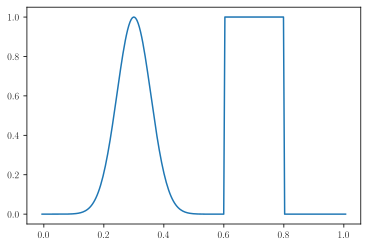

In [18]:
plt.plot(x, phi0)

In [19]:
cfl = 0.5
c = 1.
dt = cfl*dx/abs(c)
print(f'dt: {dt}\ndx: {dx}')

dt: 0.001953125
dx: 0.00390625


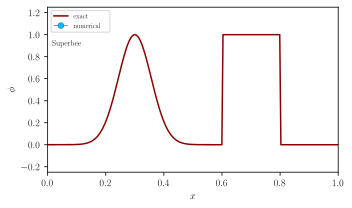

In [24]:
# finite volume implementation with arrays for fluxes
t = 0
tend = L/abs(c)
sol = []
sol.append(phi0)
ims = []

fig = plt.figure(figsize=[5,3], dpi=200)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rc('text', usetex=True)

#plt.grid()
plt.xlim([0.,L])
plt.ylim([-0.25,1.25])
plt.xlabel('$x$')
plt.ylabel('$\phi$')
plt.tight_layout()
# plot initial condition
plt.plot(x,phi0,'darkred',animated=True)

schemename = 'Bounded CD'

i = 0
while t < tend:
    phin = sol[-1]
    
    # impose periodic conditions
    phin[-2] = phin[2]
    phin[-1] = phin[3]
    phin[0] = phin[-4]
    phin[1] = phin[-3]
    
    if (i%2==0):
        shift = int(np.ceil(c*(t-dt)/dx))
        im = plt.plot(x[2:-2], np.roll(phin[2:-2], -shift), 'k-o', markevery=2,
                     markerfacecolor='deepskyblue', markeredgewidth=0.25,markeredgecolor='k',
                     linewidth=0.45, animated=True)
        ims.append(im)
    
    phi = np.zeros_like(phi0)
    
    # predictor - take half a step and use upwind
    # du/dt = -c*du/dx
    if c >= 0:
        ϕc = phin[1:-2] # phi upwind
    else:
        ϕc = phin[2:-1] # phi upwind
        
    f[2:-2] = c*ϕc
    phi[2:-2] = phin[2:-2] - dt/2./dx*(f[3:-2]-f[2:-3])
    phi[-2] = phi[2]
    phi[-1] = phi[3]
    phi[0] = phi[-4]
    phi[1] = phi[-3]
    
    # du/dt = -c*du/dx
    if c >= 0:
        ϕc = phi[1:-2] # phi upwind
        ϕu = phi[:-3]  # phi far upwind
        ϕd = phi[2:-1] # phi downwind
    else:
        ϕc = phi[2:-1] # phi upwind
        ϕu = phi[3:]  # phi far upwind
        ϕd = phi[1:-2] # phi downwind
        
    # compute r - ratio of successive gradients
    numerator = ϕc - ϕu
    denominator = ϕd - ϕc
    # find the locations where the denominator is > 1e-12 and do divisions there, otherwise set phi to 1
    divideloc = np.where(np.abs(denominator)>1e-6)
    i1 = np.where(numerator < 1e-12)
    r = np.ones_like(ϕc)
    r[divideloc] = numerator[divideloc]/denominator[divideloc]
    
    # compute face values 
    ϕf = np.zeros_like(ϕc)
    
    # superbee
    schemename = 'Superbee'
    a1 = np.maximum(0, np.minimum(1., 2.*r))
    psi = np.maximum(a1, np.minimum(2., r))
    
    # retrieve phif from phiftilde
    ϕf = ϕc + 0.5*psi*(ϕd - ϕc)
    f[2:-2] = ϕf
    f = c*f # multiply the flux by the velocity
    # advect
    phi[2:-2] = phin[2:-2] - dt/dx*(f[3:-2]-f[2:-3])
    t += dt
    i += 1
    sol.append(phi)
    
plt.annotate(schemename, xy=(0.5, 0.8), xytext=(0.015, 0.9),fontsize=8)
plt.legend(('exact','numerical'),loc='upper left',fontsize=7)
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)

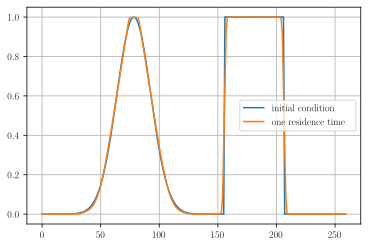

In [25]:
plt.plot(sol[0], label='initial condition')
plt.plot(sol[-1], label='one residence time')
plt.legend()
plt.grid()

In [26]:
ani

In [27]:
import sympy

In [28]:
sympy.vector.dyadic(v)

AttributeError: module 'sympy' has no attribute 'vector'